In [1]:
from pathlib import Path
import torch
from torch import nn
from torchvision import models
from mltools import ld, draw, MachineLearning

In [2]:
train_iter, val_iter, test_iter = ld.mnist('../data', batch_size=1000)  # 获取训练集、验证集和测试集
model = models.resnet18()  # 加载模型
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 修改输入通道数
device = torch.device('cuda')  # 设置设备


class ResNetMachineLearning(MachineLearning):
    def show_pred(self, contents, preds, reals):
        labels = [f'real:{reals[index]}\npred:{preds[index]}' for index in range(len(reals))]
        draw.images(contents.squeeze(1), labels, shape=(2, 5))


ml = ResNetMachineLearning(model, train_iter, val_iter, test_iter, device=device)
model_path = '../model/ResNet.pth'

train loss 0.155, val loss 0.181, val acc 0.951
20.9 sec/epoch on cuda


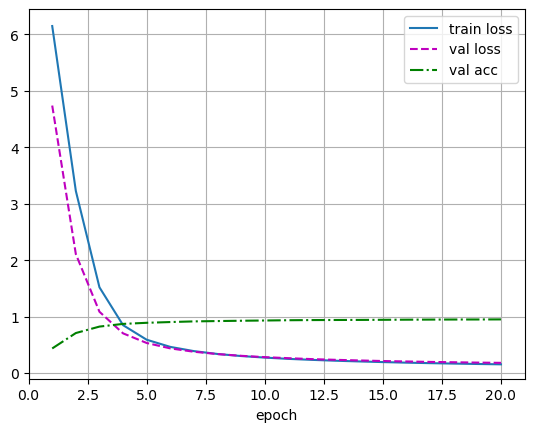

In [3]:
if True:
    ml.train(num_epochs=20, learning_rate=1e-3)  # 训练
    if True:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))

In [4]:
ml.test()  # 测试

Accuracy rate 0.9522


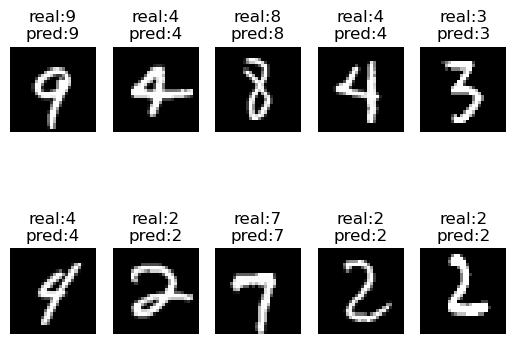

In [5]:
ml.predict()  # 预测